## Project Choice #2

http://coursera.h2o.ai/cacao.882.csv

This is a classification problem. You have to predict "Maker Location" (notice the space). In other words, using the rating, and the other fields, how accurately can you identify if it is Belgian chocolate, French chocolate, and so on.

You should split the data into train, valid and test. Use a seed (of your choice) to make your experiments more reproducible. Alternatively, you can split into just train and test, and then use cross-validation.

## Step 1

In [53]:
## Step one is to start h2o, load your data set, and split it if necessary. By the end of this stage you should have 
## three variables, pointing to three data frames on h2o: train, valid, test. However, if you are choosing to use 
## cross-validation, you will only have two: train and test.

In [1]:
import h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
h2o.init() # h2o.clusterStatus()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 14 hours 21 mins
H2O cluster version:,3.13.0.3978
H2O cluster version age:,4 years and 9 days !!!
H2O cluster name:,H2O_started_from_R_Sandipan.Dey_kpl973
H2O cluster total nodes:,1
H2O cluster free memory:,2.540 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [5]:
df_cacao_882 = h2o.import_file('http://coursera.h2o.ai/cacao.882.csv', destination_frame = "cacao_882")
#h2o_df.head()
#h2o_df.summary()
df_cacao_882.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:1795
Cols:9




,Maker,Origin,REF,Review Date,Cocoa Percent,Maker Location,Rating,Bean Type,Bean Origin
type,enum,enum,int,int,real,enum,real,enum,enum
mins,,,5.0,2006.0,0.42,,1.0,,
mean,,,1035.9047353760463,2012.325348189414,0.7169832869080773,,3.185933147632313,,
maxs,,,1952.0,2017.0,1.0,,5.0,,
sigma,,,552.8863650101442,2.92721027766861,0.06323118338429189,,0.4780623935863306,,
zeros,,,0,0,0,,0,,
missing,0,0,0,0,0,0,0,1,1
0,A. Morin,Agua Grande,1876.0,2016.0,0.63,France,3.75,Â,Sao Tome
1,A. Morin,Kpime,1676.0,2015.0,0.7000000000000001,France,2.75,Â,Togo
2,A. Morin,Atsane,1676.0,2015.0,0.7000000000000001,France,3.0,Â,Togo


In [17]:
loc_table = df_cacao_882['Maker Location'].group_by(by=['Maker Location']).count() \
                              .get_frame().as_data_frame().sort_values(by=['nrow'], ascending=False)
loc_table

,Maker Location,nrow
56,U.S.A.,764
18,France,156
7,Canada,125
55,U.K.,96
29,Italy,63
14,Ecuador,54
2,Australia,49
4,Belgium,40
54,Switzerland,38
19,Germany,35


As can be seen from the above table, some of the locations have too few records, which will result in poor accuracy of the model to be learnt on after splitting the dataset into train, validation and test datasets. Let's get rid of the locations that have small number of (< 40) examples in the dataset, to make the results more easily comprehendable, by reducing number of categories in the output variable.

In [25]:
## filter out the countries for which there is < 40 examples present in the dataset
loc_gt_40_recs = loc_table[loc_table.nrow >= 40]['Maker Location'].tolist()
print(loc_gt_40_recs)
df_cacao_882_sub = df_cacao_882[df_cacao_882['Maker Location'].isin(loc_gt_40_recs),:]
df_cacao_882_sub.head()

['U.S.A.', 'France', 'Canada', 'U.K.', 'Italy', 'Ecuador', 'Australia', 'Belgium']


Maker,Origin,REF,Review Date,Cocoa Percent,Maker Location,Rating,Bean Type,Bean Origin
A. Morin,Agua Grande,1876,2016,0.63,France,3.75,Â,Sao Tome
A. Morin,Kpime,1676,2015,0.7,France,2.75,Â,Togo
A. Morin,Atsane,1676,2015,0.7,France,3,Â,Togo
A. Morin,Akata,1680,2015,0.7,France,3.5,Â,Togo
A. Morin,Quilla,1704,2015,0.7,France,3.5,Â,Peru
A. Morin,Carenero,1315,2014,0.7,France,2.75,Criollo,Venezuela
A. Morin,Cuba,1315,2014,0.7,France,3.5,Â,Cuba
A. Morin,Sur del Lago,1315,2014,0.7,France,3.5,Criollo,Venezuela
A. Morin,Puerto Cabello,1319,2014,0.7,France,3.75,Criollo,Venezuela
A. Morin,Pablino,1319,2014,0.7,France,4,Â,Peru


In [26]:
df_cacao_882_sub['Maker Location'].table()

Maker Location,Count
Australia,49
Belgium,40
Canada,125
Ecuador,54
France,156
Italy,63
U.K.,96
U.S.A.,764


In [27]:
train, valid, test = df_cacao_882_sub.split_frame(ratios = [0.8, 0.1], 
                                              destination_frames = ['train', 'valid', 'test'], 
                                              seed = 321)

In [28]:
print("%d/%d/%d" %(train.nrows, valid.nrows, test.nrows))

1082/138/127


## Step 2

In [29]:
## Step two is to set x to be the list of columns you will use to train on, to be the column you will learn. Your choice of 
## y decides if it will be a classification or a regression.

In [34]:
ignore_fields = ['Review Date', 'Bean Type', 'Maker Location']

In [36]:
# Specify the response and predictor columns
y = 'Maker Location' # multinomial Classification
x = [i for i in train.names if not i in ignore_fields]

## Step 3

In [37]:
## Step three is to create a baseline deep learning model. It is recommended to use all default settings (remembering to 
## specify either nfolds or validation_frame); if you want to use different settings you should include a comment in your 
## source file justifying this. Allowable reasons are that the default settings were taking too long on your hardware, or 
## that they were over-fitting. Your script must include timing code.

In [38]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

model = H2ODeepLearningEstimator() 

%time model.train(x = x, y = y, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 8.66 s


In [39]:
model.model_performance(train).mean_per_class_error()

0.009105734513543521

In [40]:
model.model_performance(valid).mean_per_class_error()

0.0370347308703473

In [41]:
perf_test = model.model_performance(test)

In [42]:
print('Mean class error', perf_test.mean_per_class_error())
print('log loss', perf_test.logloss())
print('MSE', perf_test.mse())
print('RMSE', perf_test.rmse())

Mean class error 0.039057859198704276
log loss 0.6562691090589137
MSE 0.1970419316539613
RMSE 0.4438940545377481


In [43]:
perf_test.hit_ratio_table()

Top-10 Hit Ratios: 


k,hit_ratio
1,0.7559055
2,0.9527559
3,0.9763780
4,0.984252
5,0.984252
6,0.992126
7,1.0
8,1.0
9,1.0
10,1.0


In [44]:
perf_test.confusion_matrix().as_data_frame()

,Amsterdam,Argentina,Australia,Austria,Belgium,Bolivia,Brazil,Canada,Chile,Colombia,...,Suriname,Sweden,Switzerland,U.K.,U.S.A.,Venezuela,Vietnam,Wales,Error,Rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,1 / 5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1 / 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.183099,13 / 71
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0


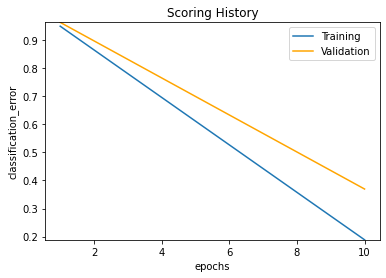

In [271]:
model.plot()

## Step 4

In [62]:
## Step four is to produce a tuned model, that gives superior performance. However you should use no more than 10 times 
## the running time of your baseline model, so again your script should be timing the model.

In [296]:
model_tuned = H2ODeepLearningEstimator(epochs=200, 
                                       distribution="multinomial",
                                       activation="RectifierWithDropout",
                                       stopping_rounds=5, 
                                       stopping_tolerance=0, 
                                       stopping_metric="logloss",
                                       input_dropout_ratio=0.2,
                                       l1=1e-5,
                                       hidden=[200,200,200])
%time model_tuned.train(x, y, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 23.8 s


In [297]:
model_tuned.model_performance(train).mean_per_class_error()

0.0

In [298]:
model_tuned.model_performance(valid).mean_per_class_error()

0.07525252525252525

In [299]:
perf_test = model_tuned.model_performance(test)
print('Mean class error', perf_test.mean_per_class_error())
print('log loss', perf_test.logloss())
print('MSE', perf_test.mse())
print('RMSE', perf_test.rmse())

Mean class error 0.09962121212121211
log loss 0.14914048100263927
MSE 0.043523282338803496
RMSE 0.20862234381485484


In [300]:
perf_test.hit_ratio_table()

Top-8 Hit Ratios: 


k,hit_ratio
1,0.9527559
2,0.9763780
3,0.9763780
4,0.992126
5,1.0
6,1.0
7,1.0
8,1.0


In [301]:
perf_test.confusion_matrix().as_data_frame()

,Australia,Belgium,Canada,Ecuador,France,Italy,U.K.,U.S.A.,Error,Rate
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0 / 5
1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0 / 3
2,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.000000,0 / 13
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.333333,1 / 3
4,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,0.090909,1 / 11
5,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.100000,1 / 10
6,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.272727,3 / 11
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,0.000000,0 / 71
8,5.0,3.0,13.0,2.0,10.0,9.0,8.0,77.0,0.047244,6 / 127


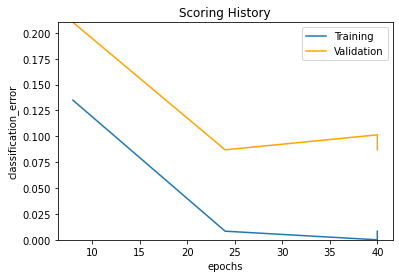

In [302]:
m_100_epochs.plot()

As can be seen from the above plot, the model started to overfit slightly, but early stopping stopped it.

## Step 5

In [290]:
# Step five is to save both your models, to your local disk, and they should be submitted with your script. 
# Use saveModel() (in R) or save_model() (Python), to export the binary version of the model. (Do not export a POJO.)

In [307]:
h2o.save_model(model, 'base_model')
h2o.save_model(model_tuned, 'tuned_model')

'C:\\Users\\Sandipan.Dey\\Documents\\tuned_model\\DeepLearning_model_python_1628664387786_42'